# LIGHT вариант 2

In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras import utils #Для to_categorical
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков
#Отрисовка графиков в ячейках collab
%matplotlib inline 
from tensorflow.keras.optimizers import Adam, RMSprop #Оптимизатор для задания шага обучения
from tensorflow.keras.models import Sequential, Model #Два формата модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, SpatialDropout1D, Conv2D, LSTM, MaxPooling1D #Базовые слови
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных


from tensorflow.keras import backend as K
from keras.callbacks import LambdaCallback

#Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Подключаем Google drive
from google.colab import drive
drive.mount('/content/drive')
#Базу для ноутбука можно скачать по ссылке
#http://marsyas.info/downloads/datasets.html

Mounted at /content/drive


In [ ]:
import zipfile #Для разорхивации базы

#Разорхивируем архив с базой
z = zipfile.ZipFile('/content/drive/My Drive/Базы/genres.zip', 'r')
z.extractall()

#Задаём названия жанров
#В архиве названия папок совпадают с названиями жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
#Функция параметризации аудир
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr)) #Частота цветности
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #Спектральный центроид
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #Ширина полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Спектральный спад частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты
  
  #Добавляем все параметры в один список
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  #По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список
  return out

In [ ]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [ ]:
import time #Дл подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()
path_ = '/content/drive/My Drive/ДЗ21 Аудио'
#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(path_+f'/genres/{g}'):
    #Получаем имя песни
    songname = path_+f'/genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30)
    #Превращаем сигнал в параметризованные данныеБМ и питон ещё нет
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 189c
Жанр classical готов -> 184c
Жанр country готов -> 191c
Жанр disco готов -> 193c
Жанр hiphop готов -> 190c
Жанр jazz готов -> 191c
Жанр metal готов -> 190c
Жанр pop готов -> 189c
Жанр reggae готов -> 193c
Жанр rock готов -> 192c


In [ ]:
np.save('/content/drive/My Drive/ДЗ21 Аудио/X_train.npy', X_train)
np.save('/content/drive/My Drive/ДЗ21 Аудио/Y_train.npy', Y_train)


In [ ]:
X_train = np.load('/content/drive/My Drive/ДЗ21 Аудио/X_train.npy')
Y_train = np.load('/content/drive/My Drive/ДЗ21 Аудио/Y_train.npy')

In [ ]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# X_train = X_train_backup.copy()
# Y_train = Y_train_backup.copy()

In [ ]:
y_train_class = np.argmax(Y_train,axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y_train_class, test_size=0.1)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(900, 26)
(900,)
(100, 26)
(100,)


## пункт 2

Epoch 1/200
45/45 [==============================] - 0s 5ms/step - loss: 1.7597 - accuracy: 0.3689 - val_loss: 1.5194 - val_accuracy: 0.4800
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 1.4029 - accuracy: 0.5167 - val_loss: 1.3885 - val_accuracy: 0.5400
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 1.2406 - accuracy: 0.5700 - val_loss: 1.2976 - val_accuracy: 0.5700
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 1.1330 - accuracy: 0.6322 - val_loss: 1.2202 - val_accuracy: 0.6000
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 1.0534 - accuracy: 0.6589 - val_loss: 1.1991 - val_accuracy: 0.6200
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.6744 - val_loss: 1.1413 - val_accuracy: 0.6700
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 0.9483 - accuracy: 0.6922 - val_loss: 1.1172 - val_accuracy: 0.6500
Epoch 8/200
4

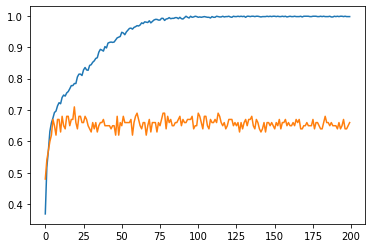

In [ ]:
# модель с вебинара
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(26,)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## пункт 3

Epoch 1/200
45/45 [==============================] - 0s 3ms/step - loss: 2.1413 - accuracy: 0.2278 - val_loss: 1.9349 - val_accuracy: 0.3400
Epoch 2/200
45/45 [==============================] - 0s 1ms/step - loss: 1.9243 - accuracy: 0.3267 - val_loss: 1.7970 - val_accuracy: 0.3800
Epoch 3/200
45/45 [==============================] - 0s 1ms/step - loss: 1.8144 - accuracy: 0.3778 - val_loss: 1.7300 - val_accuracy: 0.4500
Epoch 4/200
45/45 [==============================] - 0s 1ms/step - loss: 1.7367 - accuracy: 0.4100 - val_loss: 1.6806 - val_accuracy: 0.4500
Epoch 5/200
45/45 [==============================] - 0s 1ms/step - loss: 1.6749 - accuracy: 0.4444 - val_loss: 1.6423 - val_accuracy: 0.4600
Epoch 6/200
45/45 [==============================] - 0s 1ms/step - loss: 1.6221 - accuracy: 0.4500 - val_loss: 1.6150 - val_accuracy: 0.4800
Epoch 7/200
45/45 [==============================] - 0s 1ms/step - loss: 1.5785 - accuracy: 0.4667 - val_loss: 1.5849 - val_accuracy: 0.5100
Epoch 8/200
4

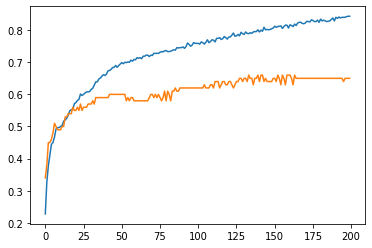

In [ ]:
# простая модель с одним скрытым слоем
model = Sequential()
model.add(Dense(64, activation='elu', input_shape=(26,)))
model.add(Dense(10, activation='elu'))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## пункт 4

Epoch 1/200
45/45 [==============================] - 1s 19ms/step - loss: 1.5794 - accuracy: 0.4511 - val_loss: 1.4797 - val_accuracy: 0.5500
Epoch 2/200
45/45 [==============================] - 1s 16ms/step - loss: 1.2097 - accuracy: 0.5844 - val_loss: 1.1631 - val_accuracy: 0.6200
Epoch 3/200
45/45 [==============================] - 1s 15ms/step - loss: 1.0484 - accuracy: 0.6378 - val_loss: 1.1392 - val_accuracy: 0.6400
Epoch 4/200
45/45 [==============================] - 1s 16ms/step - loss: 0.9444 - accuracy: 0.6644 - val_loss: 1.2072 - val_accuracy: 0.5700
Epoch 5/200
45/45 [==============================] - 1s 16ms/step - loss: 0.8657 - accuracy: 0.7056 - val_loss: 1.1431 - val_accuracy: 0.6200
Epoch 6/200
45/45 [==============================] - 1s 16ms/step - loss: 0.7532 - accuracy: 0.7456 - val_loss: 1.2675 - val_accuracy: 0.6500
Epoch 7/200
45/45 [==============================] - 1s 16ms/step - loss: 0.6569 - accuracy: 0.7644 - val_loss: 1.1963 - val_accuracy: 0.6300
Epoch 

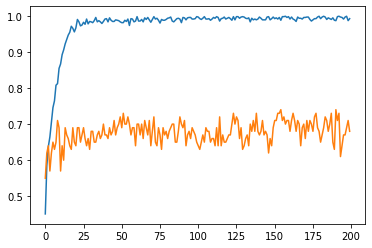

In [ ]:
# модель с 7 скрытыми слоями
model = Sequential()
model.add(Dense(512, activation='elu', input_shape=(26,)))
model.add(Dense(800, activation='elu'))
model.add(Dense(600, activation='elu'))
model.add(Dense(400, activation='elu'))
model.add(Dense(200, activation='elu'))
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

пункт 5

Epoch 1/200
45/45 [==============================] - 1s 19ms/step - loss: 2.2492 - accuracy: 0.2489 - val_loss: 1.5565 - val_accuracy: 0.4300
Epoch 2/200
45/45 [==============================] - 1s 17ms/step - loss: 2.0793 - accuracy: 0.2778 - val_loss: 1.3918 - val_accuracy: 0.5600
Epoch 3/200
45/45 [==============================] - 1s 16ms/step - loss: 1.9590 - accuracy: 0.3289 - val_loss: 1.4201 - val_accuracy: 0.5300
Epoch 4/200
45/45 [==============================] - 1s 16ms/step - loss: 1.8858 - accuracy: 0.3456 - val_loss: 1.2517 - val_accuracy: 0.6000
Epoch 5/200
45/45 [==============================] - 1s 16ms/step - loss: 1.7630 - accuracy: 0.4067 - val_loss: 1.3650 - val_accuracy: 0.5800
Epoch 6/200
45/45 [==============================] - 1s 17ms/step - loss: 1.7263 - accuracy: 0.4111 - val_loss: 1.2346 - val_accuracy: 0.6100
Epoch 7/200
45/45 [==============================] - 1s 16ms/step - loss: 1.7029 - accuracy: 0.4167 - val_loss: 1.2763 - val_accuracy: 0.5300
Epoch 

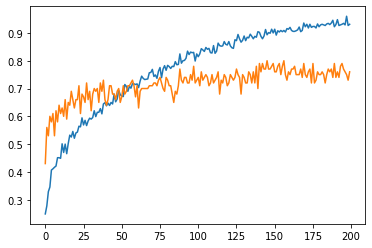

In [ ]:
# +Dropout
model = Sequential()
model.add(Dense(512, activation='elu', input_shape=(26,)))
model.add(Dropout(0.3))
model.add(Dense(800, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(600, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(400, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## пункт 6

Epoch 1/200
45/45 [==============================] - 1s 24ms/step - loss: 2.5105 - accuracy: 0.2100 - val_loss: 1.6500 - val_accuracy: 0.4400
Epoch 2/200
45/45 [==============================] - 1s 19ms/step - loss: 2.1139 - accuracy: 0.2789 - val_loss: 1.5299 - val_accuracy: 0.4500
Epoch 3/200
45/45 [==============================] - 1s 19ms/step - loss: 2.0197 - accuracy: 0.3122 - val_loss: 1.4512 - val_accuracy: 0.5200
Epoch 4/200
45/45 [==============================] - 1s 19ms/step - loss: 1.8634 - accuracy: 0.3700 - val_loss: 1.3222 - val_accuracy: 0.5000
Epoch 5/200
45/45 [==============================] - 1s 19ms/step - loss: 1.8031 - accuracy: 0.3811 - val_loss: 1.3485 - val_accuracy: 0.5200
Epoch 6/200
45/45 [==============================] - 1s 19ms/step - loss: 1.7600 - accuracy: 0.3789 - val_loss: 1.3133 - val_accuracy: 0.5400
Epoch 7/200
45/45 [==============================] - 1s 19ms/step - loss: 1.7354 - accuracy: 0.4000 - val_loss: 1.2823 - val_accuracy: 0.5800
Epoch 

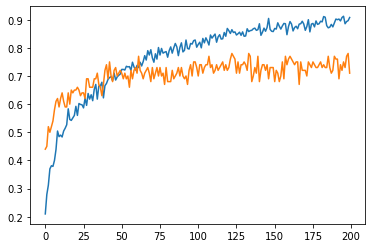

In [ ]:
# +BatchNormalization
model = Sequential()
model.add(Dense(512, activation='elu', input_shape=(26,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(800, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(600, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(400, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(200, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(100, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(50, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## пункт 7

Epoch 1/200
45/45 [==============================] - 1s 23ms/step - loss: 2.9569 - accuracy: 0.1144 - val_loss: 2.2839 - val_accuracy: 0.1800
Epoch 2/200
45/45 [==============================] - 1s 17ms/step - loss: 2.8193 - accuracy: 0.1233 - val_loss: 2.2332 - val_accuracy: 0.2000
Epoch 3/200
45/45 [==============================] - 1s 18ms/step - loss: 2.6222 - accuracy: 0.1489 - val_loss: 2.1651 - val_accuracy: 0.2500
Epoch 4/200
45/45 [==============================] - 1s 18ms/step - loss: 2.4972 - accuracy: 0.1700 - val_loss: 2.0246 - val_accuracy: 0.3500
Epoch 5/200
45/45 [==============================] - 1s 19ms/step - loss: 2.3745 - accuracy: 0.1911 - val_loss: 1.9330 - val_accuracy: 0.3400
Epoch 6/200
45/45 [==============================] - 1s 18ms/step - loss: 2.2731 - accuracy: 0.2489 - val_loss: 1.7801 - val_accuracy: 0.3700
Epoch 7/200
45/45 [==============================] - 1s 17ms/step - loss: 2.1581 - accuracy: 0.2722 - val_loss: 1.6207 - val_accuracy: 0.4700
Epoch 

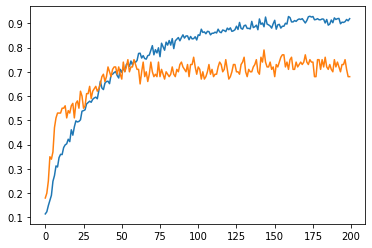

In [ ]:
# relu
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(26,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(800, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(600, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(400, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/200
45/45 [==============================] - 1s 22ms/step - loss: 2.2871 - accuracy: 0.2389 - val_loss: 1.7138 - val_accuracy: 0.4800
Epoch 2/200
45/45 [==============================] - 1s 18ms/step - loss: 2.0259 - accuracy: 0.3122 - val_loss: 1.5441 - val_accuracy: 0.4200
Epoch 3/200
45/45 [==============================] - 1s 18ms/step - loss: 1.8650 - accuracy: 0.3556 - val_loss: 1.4184 - val_accuracy: 0.4800
Epoch 4/200
45/45 [==============================] - 1s 18ms/step - loss: 1.8075 - accuracy: 0.3767 - val_loss: 1.4230 - val_accuracy: 0.4800
Epoch 5/200
45/45 [==============================] - 1s 18ms/step - loss: 1.7496 - accuracy: 0.3911 - val_loss: 1.4216 - val_accuracy: 0.5500
Epoch 6/200
45/45 [==============================] - 1s 19ms/step - loss: 1.7548 - accuracy: 0.3767 - val_loss: 1.3620 - val_accuracy: 0.5700
Epoch 7/200
45/45 [==============================] - 1s 18ms/step - loss: 1.6849 - accuracy: 0.4178 - val_loss: 1.3367 - val_accuracy: 0.5100
Epoch 

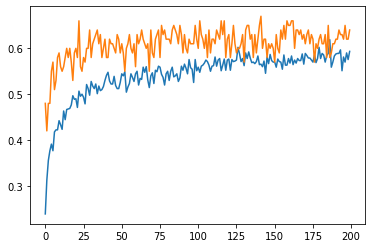

In [ ]:
# linear
model = Sequential()
model.add(Dense(512, activation='linear', input_shape=(26,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(800, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(600, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(400, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(200, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(100, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(50, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## пункт 8

Epoch 1/200
90/90 [==============================] - 2s 22ms/step - loss: 2.4718 - accuracy: 0.1933 - val_loss: 1.6324 - val_accuracy: 0.4400
Epoch 2/200
90/90 [==============================] - 2s 17ms/step - loss: 2.0811 - accuracy: 0.2878 - val_loss: 1.5514 - val_accuracy: 0.4500
Epoch 3/200
90/90 [==============================] - 1s 16ms/step - loss: 1.9724 - accuracy: 0.3278 - val_loss: 1.5037 - val_accuracy: 0.4800
Epoch 4/200
90/90 [==============================] - 1s 16ms/step - loss: 1.9544 - accuracy: 0.3322 - val_loss: 1.3750 - val_accuracy: 0.5500
Epoch 5/200
90/90 [==============================] - 1s 16ms/step - loss: 1.8400 - accuracy: 0.3544 - val_loss: 1.3998 - val_accuracy: 0.5200
Epoch 6/200
90/90 [==============================] - 1s 16ms/step - loss: 1.7233 - accuracy: 0.4067 - val_loss: 1.3290 - val_accuracy: 0.5500
Epoch 7/200
90/90 [==============================] - 1s 16ms/step - loss: 1.7605 - accuracy: 0.3889 - val_loss: 1.3339 - val_accuracy: 0.5400
Epoch 

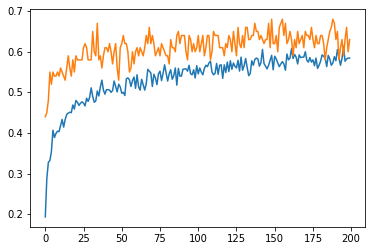

In [ ]:
# маленький batch_size
model = Sequential()
model.add(Dense(512, activation='linear', input_shape=(26,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(800, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(600, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(400, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(200, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(100, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(50, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=10,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/200
3/3 [==============================] - 0s 133ms/step - loss: 2.6217 - accuracy: 0.1800 - val_loss: 2.9752 - val_accuracy: 0.4000
Epoch 2/200
3/3 [==============================] - 0s 54ms/step - loss: 2.1495 - accuracy: 0.3022 - val_loss: 2.5680 - val_accuracy: 0.4300
Epoch 3/200
3/3 [==============================] - 0s 56ms/step - loss: 1.9994 - accuracy: 0.3422 - val_loss: 2.5560 - val_accuracy: 0.4200
Epoch 4/200
3/3 [==============================] - 0s 56ms/step - loss: 1.9461 - accuracy: 0.3267 - val_loss: 2.5759 - val_accuracy: 0.4200
Epoch 5/200
3/3 [==============================] - 0s 59ms/step - loss: 1.8423 - accuracy: 0.3722 - val_loss: 2.4320 - val_accuracy: 0.4300
Epoch 6/200
3/3 [==============================] - 0s 54ms/step - loss: 1.8447 - accuracy: 0.3811 - val_loss: 2.4342 - val_accuracy: 0.4500
Epoch 7/200
3/3 [==============================] - 0s 55ms/step - loss: 1.8307 - accuracy: 0.3800 - val_loss: 2.1940 - val_accuracy: 0.4300
Epoch 8/200
3/3 [==

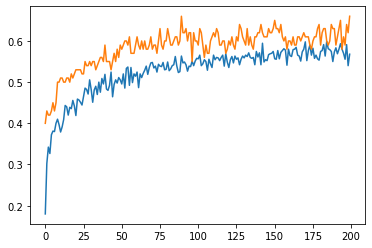

In [ ]:
# средний batch_size
model = Sequential()
model.add(Dense(512, activation='linear', input_shape=(26,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(800, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(600, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(400, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(200, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(100, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(50, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=300,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/200
2/2 [==============================] - 0s 170ms/step - loss: 2.9393 - accuracy: 0.1478 - val_loss: 2.7146 - val_accuracy: 0.3500
Epoch 2/200
2/2 [==============================] - 0s 52ms/step - loss: 2.2205 - accuracy: 0.2633 - val_loss: 2.3805 - val_accuracy: 0.4000
Epoch 3/200
2/2 [==============================] - 0s 52ms/step - loss: 2.0626 - accuracy: 0.2989 - val_loss: 2.7341 - val_accuracy: 0.4200
Epoch 4/200
2/2 [==============================] - 0s 49ms/step - loss: 1.9823 - accuracy: 0.3233 - val_loss: 2.3785 - val_accuracy: 0.4400
Epoch 5/200
2/2 [==============================] - 0s 51ms/step - loss: 1.9641 - accuracy: 0.3222 - val_loss: 2.3288 - val_accuracy: 0.4600
Epoch 6/200
2/2 [==============================] - 0s 49ms/step - loss: 1.8659 - accuracy: 0.3689 - val_loss: 2.2657 - val_accuracy: 0.4700
Epoch 7/200
2/2 [==============================] - 0s 51ms/step - loss: 1.8773 - accuracy: 0.3533 - val_loss: 2.3121 - val_accuracy: 0.4900
Epoch 8/200
2/2 [==

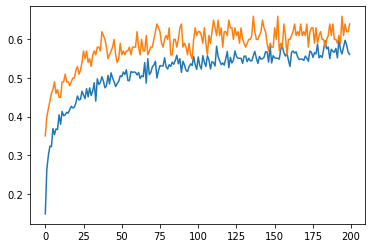

In [ ]:
# большой batch_size
model = Sequential()
model.add(Dense(512, activation='linear', input_shape=(26,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(800, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(600, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(400, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(200, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(100, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(50, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.0004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    epochs=200,
                    batch_size=600,
                    validation_data=(X_test,Y_test))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

## Выводы

Модель с вебинара:  
3 скрытых слоя, elu, batch_size = 20  
Accuracy = 99%, val_accuracy = 68%

Простая модель  
1 скрытый слой, elu, batch_size = 20  
Accuracy = 84%, val_accuracy = 66% - замер

Модель с 7 скрытыми слоями:  
7 скрытых слоев, elu, batch_size = 20  
Accuracy = 99%, val_accuracy = 73% - большая волатильность

С Dropout:  
7 скрытых слоев+Dropout 0.3, elu, batch_size = 20  
Accuracy = 96%, val_accuracy = 79% 


С Dropout и BatchNormalization:  
7 скрытых слоев+Dropout 0.3+BatchNormalization, elu, batch_size = 20  
Accuracy = 91%, val_accuracy = 78% 


Elu – на ReLu:  
7 скрытых слоев+Dropout 0.3+BatchNormalization, relu, batch_size = 20  
Accuracy = 92%, val_accuracy = 76% 

Elu – на Linear:  
7 скрытых слоев+Dropout 0.3+BatchNormalization, linear, batch_size = 20  
Accuracy = 59%%, val_accuracy = 64% 

Маленький batch_size:  
7 скрытых слоев+Dropout 0.3+BatchNormalization, linear, batch_size = 10  
Accuracy = 61%, val_accuracy = 68% 


Средний batch_size:  
7 скрытых слоев+Dropout 0.3+BatchNormalization, linear, batch_size = 300  
Accuracy = 59%%, val_accuracy = 65% 

Большой batch_size:  
7 скрытых слоев+Dropout 0.3+BatchNormalization, linear, batch_size = 600  
Accuracy = 60%, val_accuracy = 64% 



Наилучший результат дала модель с несколькими (7шт) скрытыми слоями и Dropout. BatchNormalization здесь лишние, так как дропаута хватило чтобы не допустить переобучения.
Худшим результатом среди активационных функций стала linear. Нейроны не активировались и сеть не успевала "выцепить" признаки сигналов.
Размер batch_size повлиял на результат незначительно


# Pro - Вариант 1

**обучающие и проверочные выборки взяты с задания light**

In [ ]:
x_train2 = np.expand_dims(X_train,axis=2)
x_test2 = np.expand_dims(X_test,axis=2)

In [ ]:
def on_epoch_end(epoch, logs):
  global trigger1
  global trigger2

  if logs['val_accuracy'] > 0.79 and trigger1 == 0:
    K.set_value(model.optimizer.lr, model.optimizer.lr.numpy()/10)
    trigger1 = 1
    print('Текущий lr:',model.optimizer.lr.numpy())
  if logs['val_accuracy'] > 0.8 and trigger2 == 0:
    K.set_value(model.optimizer.lr, model.optimizer.lr.numpy()/10)
    trigger2 = 1
    print('Текущий lr:',model.optimizer.lr.numpy())

pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

Epoch 1/1000
23/23 [==============================] - 0s 13ms/step - loss: 2.2157 - accuracy: 0.1967 - val_loss: 1.9479 - val_accuracy: 0.3100
Epoch 2/1000
23/23 [==============================] - 0s 6ms/step - loss: 1.9859 - accuracy: 0.3000 - val_loss: 1.8290 - val_accuracy: 0.3800
Epoch 3/1000
23/23 [==============================] - 0s 6ms/step - loss: 1.9604 - accuracy: 0.2844 - val_loss: 1.7460 - val_accuracy: 0.4000
Epoch 4/1000
23/23 [==============================] - 0s 6ms/step - loss: 1.8376 - accuracy: 0.3656 - val_loss: 1.6955 - val_accuracy: 0.4200
Epoch 5/1000
23/23 [==============================] - 0s 6ms/step - loss: 1.8412 - accuracy: 0.3822 - val_loss: 1.6631 - val_accuracy: 0.4700
Epoch 6/1000
23/23 [==============================] - 0s 6ms/step - loss: 1.8061 - accuracy: 0.3856 - val_loss: 1.6216 - val_accuracy: 0.4800
Epoch 7/1000
23/23 [==============================] - 0s 6ms/step - loss: 1.7434 - accuracy: 0.3967 - val_loss: 1.6061 - val_accuracy: 0.4700
Epoch

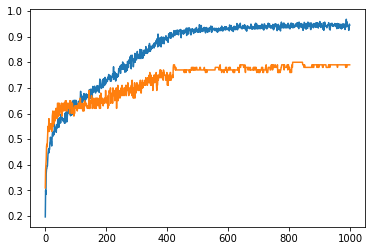

In [ ]:
'''
модель в принципе показывала и 81%, но решил соответствовать заданию и закрепить "стабильность" 
результата снижая lr
'''
trigger1 = 0
trigger2 = 0
model = Sequential()
model.add(Conv1D(128,2,padding='same', input_shape=(26,1), activation='elu'))
model.add(Conv1D(128,2, padding='same', activation='elu'))
model.add(SpatialDropout1D(0.2))
# model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(512, activation='elu', input_shape=(26,)))
model.add(Dropout(0.2))
model.add(Dense(800, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(600, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(400, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(len(genres), activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.00004), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train2, Y_train,
                    epochs=1000,
                    batch_size=40,
                    validation_data=(x_test2,Y_test),
                    callbacks=[pltMae])

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()